In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math
from Levenshtein import distance as levenshtein_distance
import seaborn as sns

# add path src folder containing util functions
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import check_sequence_similarity



In [2]:
#A3 CDR3b tiled 4xNNK library EDA
# read library data (topx_miny stands for consensus building method. x=numbers of top reads counted as variant, y=minimum read count to condider a read)

df_t4x_t1_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59053_A3t4xNNK_top1_min1_aa.csv')
df_t4x_t1_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59053_A3t4xNNK_top1_min2_aa.csv')
df_t4x_t3_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59053_A3t4xNNK_top3_min1_aa.csv')
df_t4x_t3_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59053_A3t4xNNK_top3_min2_aa.csv')

display(df_t4x_t1_m2)

df_t4xA3pos_t1_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59054_A3t4xNNKA3_top1_min1_aa.csv')
df_t4xA3pos_t1_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59054_A3t4xNNKA3_top1_min2_aa.csv')
df_t4xA3pos_t3_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59054_A3t4xNNKA3_top3_min1_aa.csv')
df_t4xA3pos_t3_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59054_A3t4xNNKA3_top3_min2_aa.csv')

df_t4xA3neg_t1_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59055_A3t4xNNKA3neg_top1_min1_aa.csv')
df_t4xA3neg_t1_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59055_A3t4xNNKA3neg_top1_min2_aa.csv')
df_t4xA3neg_t3_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59055_A3t4xNNKA3neg_top3_min1_aa.csv')
df_t4xA3neg_t3_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59055_A3t4xNNKA3neg_top3_min2_aa.csv')

df_3x_t1_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59056_A33xNNK_top1_min1_aa.csv')
df_3x_t1_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59056_A33xNNK_top1_min2_aa.csv')
df_3x_t3_m1 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59056_A33xNNK_top3_min1_aa.csv')
df_3x_t3_m2 = pd.read_csv('../data/extracted/P3303_LUCA/GFB-59056_A33xNNK_top3_min2_aa.csv')

df_t4x_no_consensus = pd.read_csv('../data/extracted/P3303_LUCA/A3t4xNNK_no_consensus_aa.csv')
df_3x_no_consensus = pd.read_csv('../data/extracted/P3303_LUCA/A33xNNK_no_consensus_aa.csv')


,umi_id,nt_seq,aa_seq
0,GGGCAGGATTGT_var1_count17,TGCGCCAGCAGCCCGAATATGCTGCCTCGGCCGTACTTC,CASSPNMLPRPYF
1,GGCTGTGCCGTT_var1_count15,TGCGCCAGCAGCCCGAATATGGCGATTAGTTCGTACTTC,CASSPNMAISSYF
2,GTTTGAGATTAT_var1_count29,TGCGCCAGCAGCCCGGGGTTTTGGTTTGAACAGTACTTC,CASSPGFWFEQYF
3,GGCGCGAGGAGT_var1_count14,TGCGCCAGCAGCCCGGTTGTGGATGTGGAACAGTACTTC,CASSPVVDVEQYF
4,AATTCCACGCGT_var1_count18,TGCGCCAGCAGCCCGAATATGGCGGATTGGCATTCTTTC,CASSPNMADWHSF
...,...,...,...
285896,ACACTATCGTTC_var1_count2,TGCGCCAGTGATCAGCTGATGGCGGATGAACAGTACTTC,CASDQLMADEQYF
285897,TTGTACTCATAC_var1_count2,TGCGCCAGCAGCCCGAATATGGCGTCTCGGGGGAGTTTC,CASSPNMASRGSF
285898,GGGGTGCATGTG_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
285899,GCACCGTGAATC_var1_count2,TGCGCCAGCGTTCTGTTTCATGCGGATGAACAGTACTTC,CASVLFHADEQYF


In [3]:
def filter_and_collapse_sequences(df, column, n):
    """
    Keeps only rows where the value in `column` appears at least `n` times in total,
    and collapses consecutive identical values in that column to a single row.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): Name of the column to check.
        n (int): Minimum number of occurrences required to keep a row.

    Returns:
        pd.DataFrame: Filtered and collapsed DataFrame.
    """
    # Count occurrences of each unique value
    counts = df[column].value_counts()

    # Keep only values that appear at least n times
    valid_values = counts[counts >= n].index

    # Filter by those values
    filtered_df = df[df[column].isin(valid_values)].copy()

    # Remove consecutive duplicates (keep first of each run)
    collapsed_df = filtered_df.loc[
        filtered_df[column].shift() != filtered_df[column]
    ].reset_index(drop=True)

    return collapsed_df

In [2]:
df_t4x_no_consensus_m42 = filter_and_collapse_sequences(df_t4x_no_consensus, 'nt_seq', 42)
df_3x_no_consensus_m42 = filter_and_collapse_sequences(df_3x_no_consensus, 'nt_seq', 42)

display(df_t4x_no_consensus, df_t4x_no_consensus_m42)
display(df_3x_no_consensus, df_3x_no_consensus_m42)

NameError: name 'df_t4x_no_consensus' is not defined

In [4]:
# Using the 'aa_seq' column 

unique_orig_t1_m1 = df_t4x_t1_m1['aa_seq'].unique()
unique_orig_t1_m2 = df_t4x_t1_m2['aa_seq'].unique()
unique_orig_t3_m1 = df_t4x_t3_m1['aa_seq'].unique()
unique_orig_t3_m2 = df_t4x_t3_m2['aa_seq'].unique()

unique_pos_t1_m1 = df_t4xA3pos_t1_m1['aa_seq'].unique()
unique_pos_t1_m2 = df_t4xA3pos_t1_m2['aa_seq'].unique()
unique_pos_t3_m1 = df_t4xA3pos_t3_m1['aa_seq'].unique()
unique_pos_t3_m2 = df_t4xA3pos_t3_m2['aa_seq'].unique()

unique_neg_t1_m1 = df_t4xA3neg_t1_m1['aa_seq'].unique()
unique_neg_t1_m2 = df_t4xA3neg_t1_m2['aa_seq'].unique()
unique_neg_t3_m1 = df_t4xA3neg_t3_m1['aa_seq'].unique()
unique_neg_t3_m2 = df_t4xA3neg_t3_m2['aa_seq'].unique()

unique_orig_3x_t1_m1 = df_3x_t1_m1['aa_seq'].unique()
unique_orig_3x_t1_m2 = df_3x_t1_m2['aa_seq'].unique()
unique_orig_3x_t3_m1 = df_3x_t3_m1['aa_seq'].unique()
unique_orig_3x_t3_m2 = df_3x_t3_m2['aa_seq'].unique()

#unique_orig_t4x_no_consensus = df_t4x_no_consensus['aa_seq'].unique()
#unique_orig_t4x_no_consensus_m42 = df_t4x_no_consensus_m42['aa_seq'].unique()
#unique_orig_3x_no_consensus = df_3x_no_consensus['aa_seq'].unique()
#unique_orig_3x_no_consensus_m42 = df_3x_no_consensus_m42['aa_seq'].unique()


In [5]:
# --- Compute edit distances ---
def compute_distances(peptide_list, wt_seq):
    total_read_count = len(peptide_list)
    return total_read_count, [levenshtein_distance(wt_seq, pep) for pep in peptide_list]



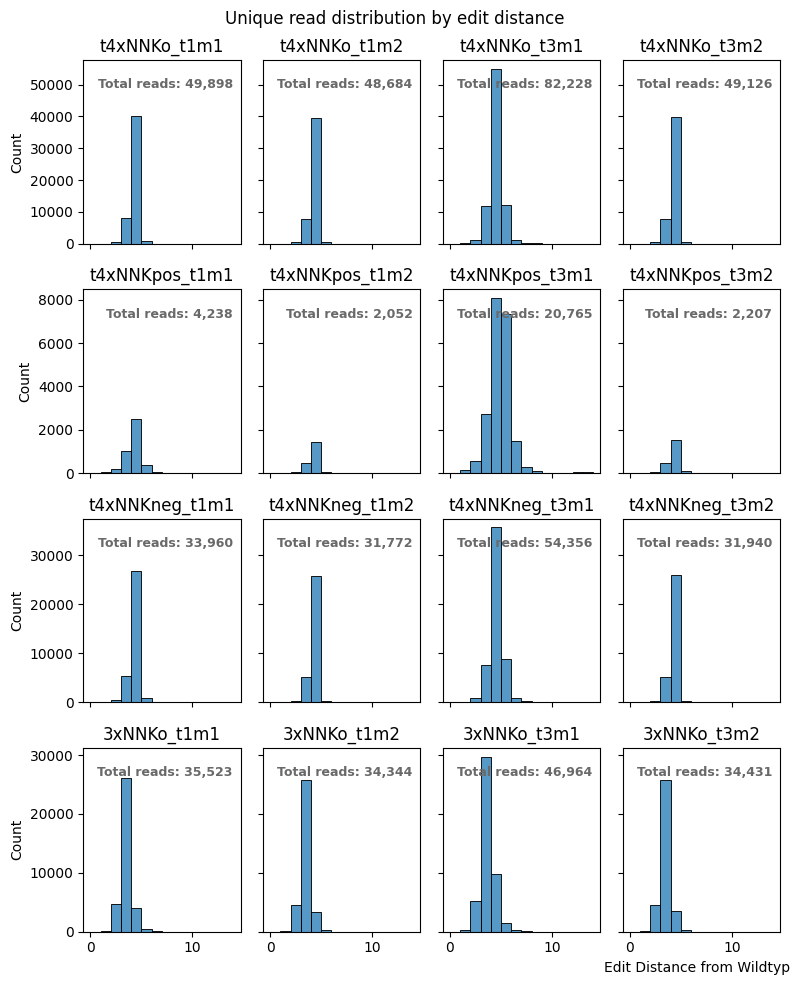

In [6]:
# plot unique variants according to their edit distances 
wildtype = 'CASSPNMADEQYF'

dist_lists = {
    "t4xNNKo_t1m1": compute_distances(unique_orig_t1_m1, wildtype),
    "t4xNNKo_t1m2": compute_distances(unique_orig_t1_m2, wildtype),
    "t4xNNKo_t3m1": compute_distances(unique_orig_t3_m1, wildtype),
    "t4xNNKo_t3m2": compute_distances(unique_orig_t3_m2, wildtype),

    "t4xNNKpos_t1m1": compute_distances(unique_pos_t1_m1, wildtype),
    "t4xNNKpos_t1m2": compute_distances(unique_pos_t1_m2, wildtype),
    "t4xNNKpos_t3m1": compute_distances(unique_pos_t3_m1, wildtype),
    "t4xNNKpos_t3m2": compute_distances(unique_pos_t3_m2, wildtype),

    "t4xNNKneg_t1m1": compute_distances(unique_neg_t1_m1, wildtype),
    "t4xNNKneg_t1m2": compute_distances(unique_neg_t1_m2, wildtype),
    "t4xNNKneg_t3m1": compute_distances(unique_neg_t3_m1, wildtype),
    "t4xNNKneg_t3m2": compute_distances(unique_neg_t3_m2, wildtype),

    "3xNNKo_t1m1": compute_distances(unique_orig_3x_t1_m1, wildtype),
    "3xNNKo_t1m2": compute_distances(unique_orig_3x_t1_m2, wildtype),
    "3xNNKo_t3m1": compute_distances(unique_orig_3x_t3_m1, wildtype),
    "3xNNKo_t3m2": compute_distances(unique_orig_3x_t3_m2, wildtype),


    #"t4xNNKo_no_cons": compute_distances(unique_orig_t4x_no_consensus, wildtype),
    #"t4xNNKo_no_cons_m2": compute_distances(unique_orig_t4x_no_consensus_m42, wildtype),
    #"3xNNKo_no_cons": compute_distances(unique_orig_3x_no_consensus, wildtype),
    #"3xNNKo_no_cons_m2": compute_distances(unique_orig_3x_no_consensus_m42, wildtype)

}


# --- Plot histograms (counts) separately ---
fig, axes = plt.subplots(4, 4, figsize=(8, 10), sharex=True, sharey='row')
axes = axes.flatten()

fig.suptitle('Unique read distribution by edit distance')

for ax, (label, (total, dists)) in zip(axes, dist_lists.items()):
    sns.histplot(dists, bins=range(min(dists), max(dists)+2), ax=ax, color="C0", edgecolor="black")
    ax.set_title(f"{label}")
    ax.text(
        0.95, 0.9,                      # Position (x%, y%) in axes coordinates
        f"Total reads: {total:,}", # Text (formatted with commas)
        transform=ax.transAxes,          # Coordinates relative to axes (not data)
        ha='right', va='top', fontsize=9, color='dimgray', fontweight='bold'
    )
    ax.set_ylabel("Count")

axes[-1].set_xlabel("Edit Distance from Wildtype")
plt.tight_layout()
plt.show()

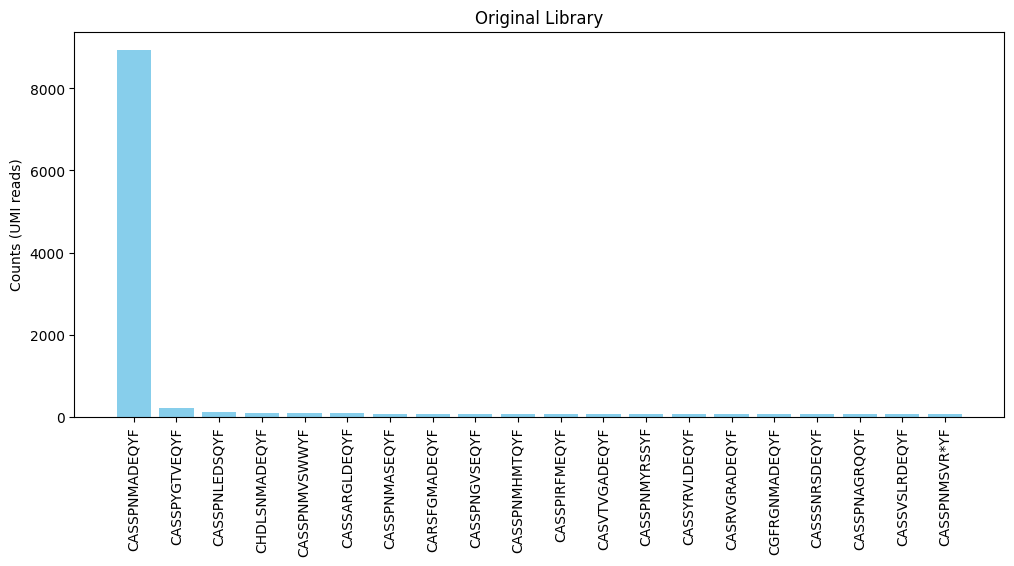

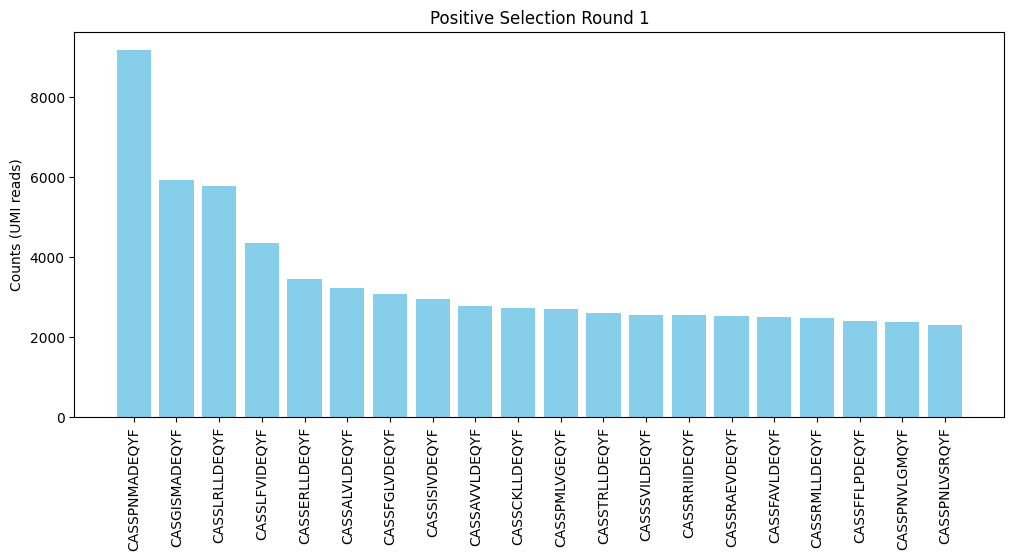

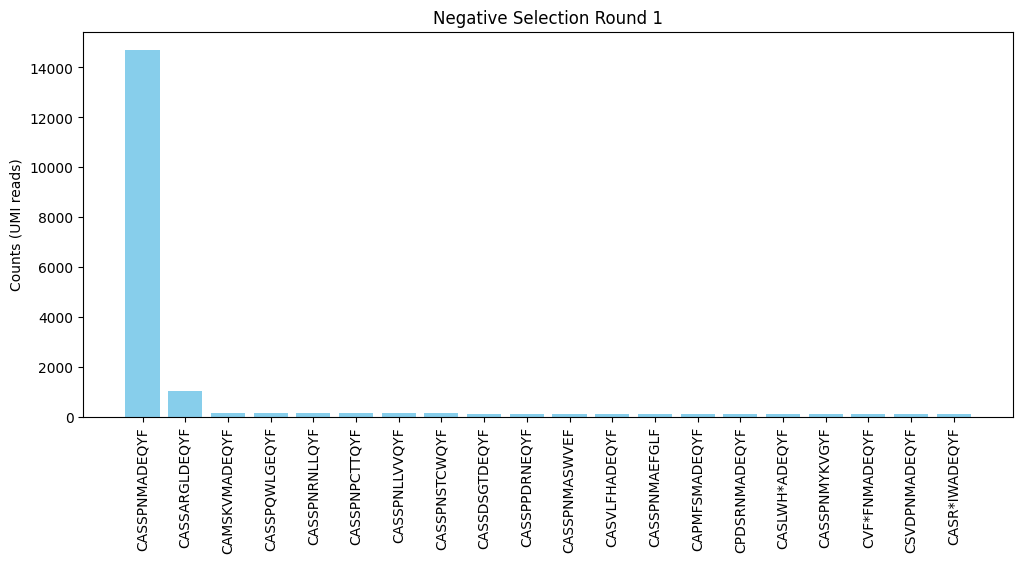

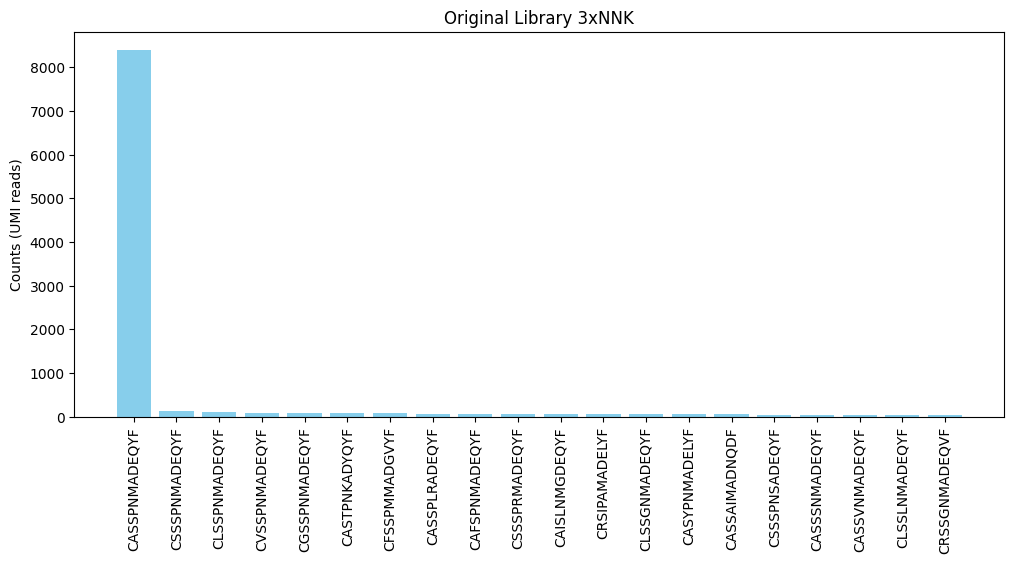

In [9]:
TOP_N = 20

def get_counts(df, seq_col='aa_seq'):
    """
    Convert a dataframe with one row per read into counts of unique sequences.
    Returns a dataframe with columns: ['cdr3', 'count']
    """
    counts = df[seq_col].value_counts().reset_index()
    counts.columns = ['cdr3', 'count']
    return counts

# Convert each dataframe to counts
df_t4x_counts = get_counts(df_t4x_t1_m2)
df_t4xA3pos_counts = get_counts(df_t4xA3pos_t1_m2)
df_t4xA3neg_counts = get_counts(df_t4xA3neg_t1_m2)
df_3x_counts = get_counts(df_3x_t1_m2)

# Plotting function
def plot_top_variants(df_counts, title='Variant distribution', top_n=TOP_N):
    df_top = df_counts.sort_values('count', ascending=False).head(top_n)
    plt.figure(figsize=(12,5))
    plt.bar(df_top['cdr3'], df_top['count'], color='skyblue')
    plt.xticks(rotation=90)
    plt.ylabel('Counts (UMI reads)')
    plt.title(title)
    plt.show()

# Plot top variants
plot_top_variants(df_t4x_counts, title='Original Library')
plot_top_variants(df_t4xA3pos_counts, title='Positive Selection Round 1')
plot_top_variants(df_t4xA3neg_counts, title='Negative Selection Round 1')
plot_top_variants(df_3x_counts, title='Original Library 3xNNK')

In [10]:
df_t4x_counts = get_counts(df_t4x_t1_m2)
df_t4x_counts


,cdr3,count
0,CASSPNMADEQYF,8935
1,CASSPYGTVEQYF,211
2,CASSPNLEDSQYF,119
3,CHDLSNMADEQYF,90
4,CASSPNMVSWWYF,79
...,...,...
48679,CCSSPNDADEQPF,1
48680,CASSPNMLMRYYF,1
48681,CAAVANMADEQYF,1
48682,CASSSRMADEQVF,1


In [11]:
def count_by_distance(counts, wildtype):
    distance_bins = Counter()
    for pep, count in zip(counts['cdr3'], counts['count']):
        dist = levenshtein_distance(wildtype, pep)
        # Group distances ≥ 4 together
        bin_label = str(dist) if dist < 5 else "4+"
        distance_bins[bin_label] += count
    return distance_bins


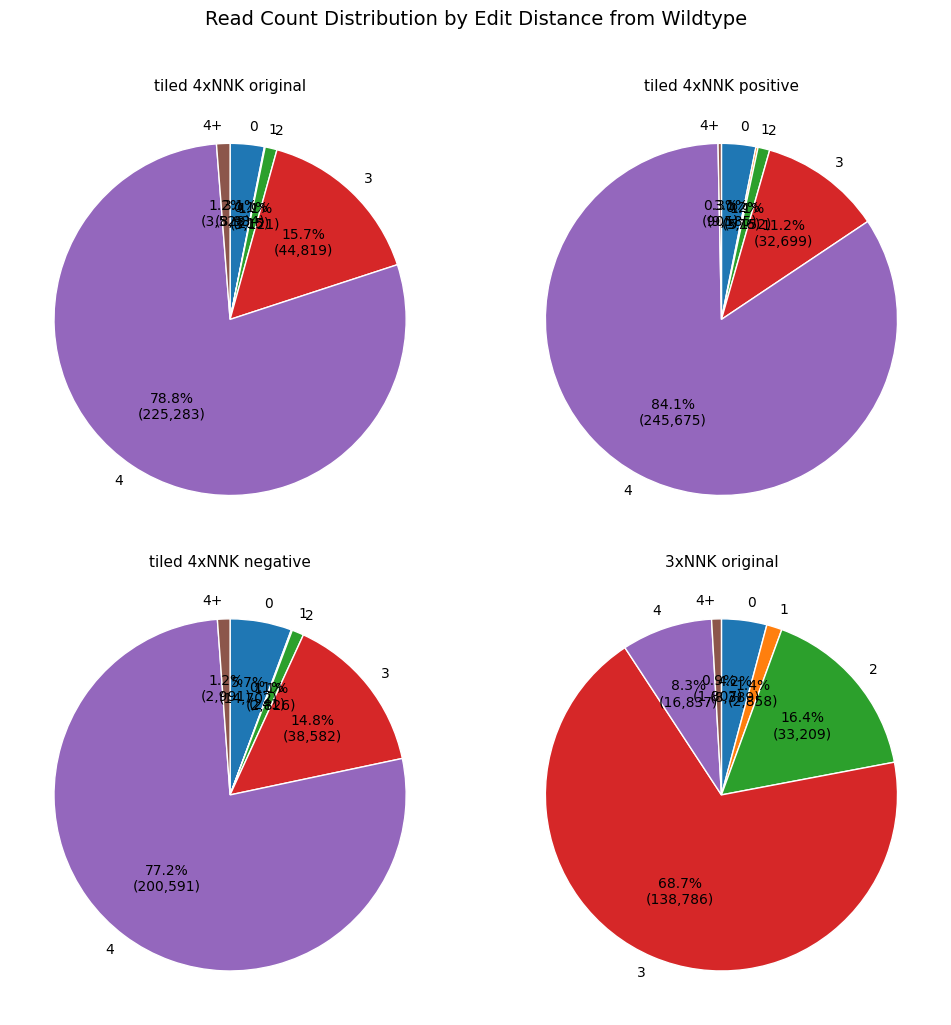

In [12]:
wildtype = "CASSPNMADEQYF"

# Define the datasets you want to analyze
datasets = {
    "tiled 4xNNK original": df_t4x_counts,
    "tiled 4xNNK positive": df_t4xA3pos_counts,
    "tiled 4xNNK negative": df_t4xA3neg_counts,
    "3xNNK original": df_3x_counts
}

# --- Compute distance bins for each dataset ---
distance_results = {name: count_by_distance(df, wildtype) for name, df in datasets.items()}

# --- Prepare consistent labels ---
labels = ["0", "1", "2", "3", "4", "4+"]

# --- Create subplots ---
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, (name, bins) in zip(axes, distance_results.items()):
    # Compute sizes (convert keys to consistent types)
    sizes = [bins.get(l, 0) for l in labels]

    # Plot pie
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=[str(l) for l in labels],
        autopct=lambda p: f"{p:.1f}%\n({int(p/100*sum(sizes)):,})",
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'white'}
    )
    ax.set_title(name, fontsize=11)

# Hide any empty subplots if <4 datasets
for ax in axes[len(distance_results):]:
    ax.set_visible(False)

plt.suptitle("Read Count Distribution by Edit Distance from Wildtype", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

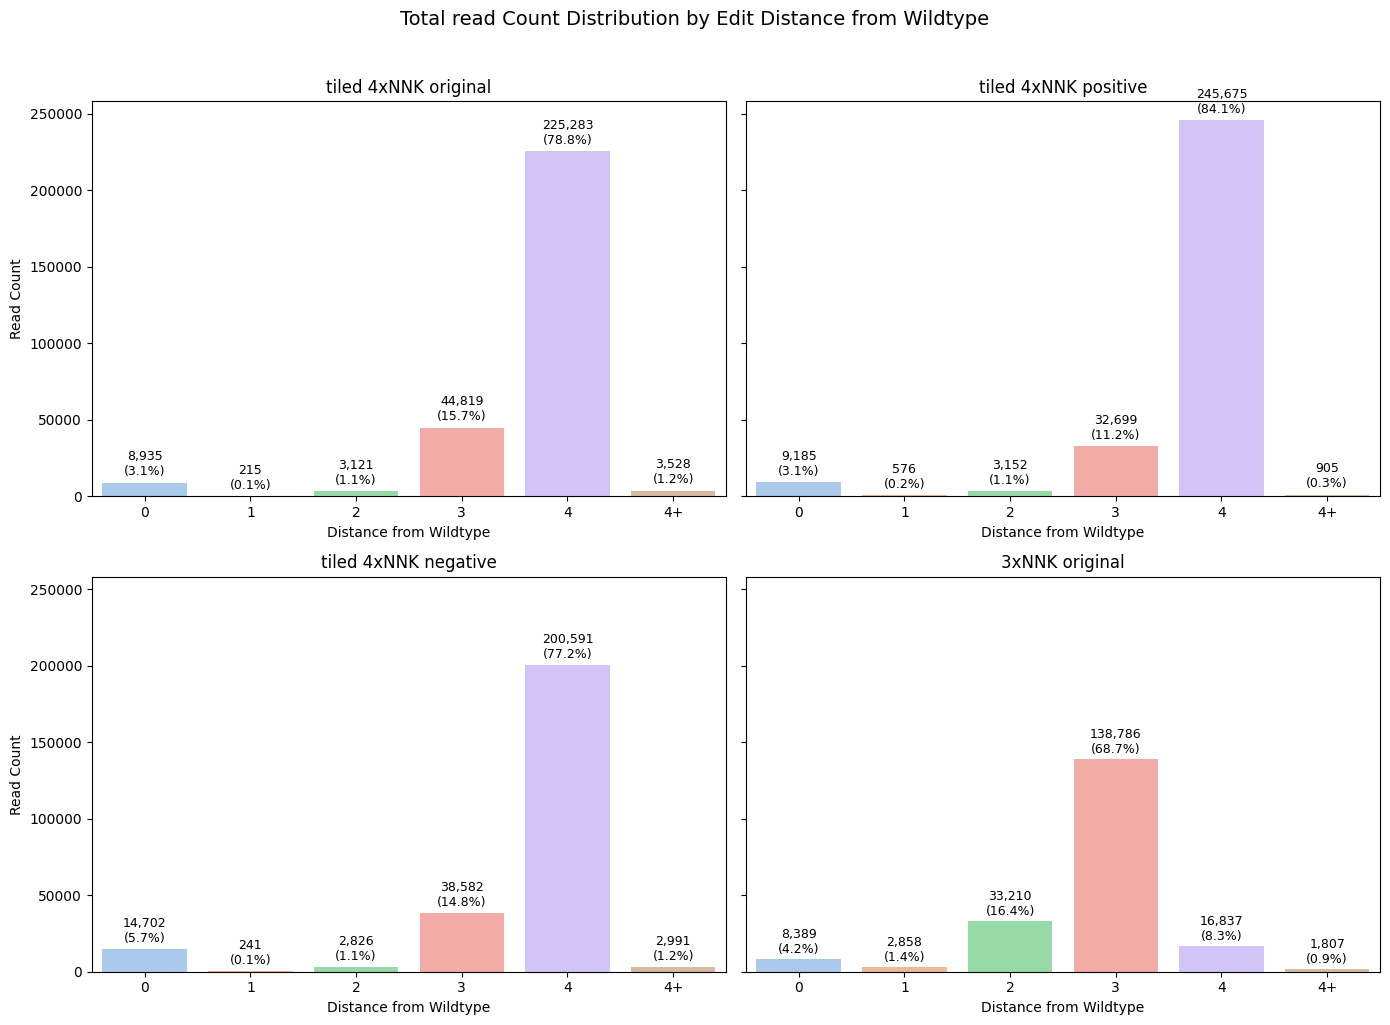

In [13]:
wildtype = "CASSPNMADEQYF"

# Define the datasets you want to analyze
datasets = {
    "tiled 4xNNK original": df_t4x_counts,
    "tiled 4xNNK positive": df_t4xA3pos_counts,
    "tiled 4xNNK negative": df_t4xA3neg_counts,
    "3xNNK original": df_3x_counts
}

# --- Compute distance bins for each dataset ---
distance_results = {name: count_by_distance(df, wildtype) for name, df in datasets.items()}


# --- Prepare labels ---
labels = ["0", "1", "2", "3", "4", "4+"]

# --- Create subplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()
fig.suptitle("Total read Count Distribution by Edit Distance from Wildtype", fontsize=14, y=1.02)

for ax, (name, df) in zip(axes, datasets.items()):
    bins = count_by_distance(df, wildtype)
    sizes = [bins.get(l, 0) for l in labels]
    total = sum(sizes)
    percentages = [s / total * 100 for s in sizes]

    # Plot barplot
    sns.barplot(x=labels, y=sizes, ax=ax, hue=labels, palette="pastel")

    # Annotate counts and percentages on top of bars
    for i, (count, pct) in enumerate(zip(sizes, percentages)):
        ax.text(i, count + total*0.01, f"{count:,}\n({pct:.1f}%)",
                ha='center', va='bottom', fontsize=9)

    ax.set_title(name, fontsize=12)
    ax.set_ylabel("Read Count")
    ax.set_xlabel("Distance from Wildtype")

plt.tight_layout()
plt.show()


In [14]:
def deleteStopCodons(df):
    mask = ~df['cdr3'].astype(str).str.contains(r'\*', na=False)
    return df[mask]

def clean_by_editpattern(df, tiled=False, max_dist=4):
    mask = df['cdr3'].apply(lambda q: check_sequence_similarity(wildtype, q , max_dist=max_dist, tiled=tiled))
    return df[mask]

def clean_by_flanking_residues(df):
    mask = df['cdr3'].apply(lambda row: row[0] == 'C' and row[-1] == 'F')
    return df[mask]

def clean_from_ambiguous(df):
    mask = df['cdr3'].apply(lambda row: 'X' not in row)
    return df[mask]

In [15]:
df_t4x_nostop = deleteStopCodons(df_t4x_counts)
df_t4xA3pos_nostop = deleteStopCodons(df_t4xA3pos_counts)
df_t4xA3neg_nostop = deleteStopCodons(df_t4xA3neg_counts)

df_t4x_sensible = clean_by_editpattern(df_t4x_nostop, max_dist=4, tiled=True)
df_t4xA3pos_sensible = clean_by_editpattern(df_t4xA3pos_nostop, max_dist=4, tiled=True)
df_t4xA3neg_sensible = clean_by_editpattern(df_t4xA3neg_nostop, max_dist=4, tiled=True)

df_t4x_sensible = clean_from_ambiguous(df_t4x_sensible)
df_t4xA3pos_sensible = clean_from_ambiguous(df_t4xA3pos_sensible)
df_t4xA3neg_sensible = clean_from_ambiguous(df_t4xA3neg_sensible)

df_t4x_clean = clean_by_flanking_residues(df_t4x_sensible)
df_t4xA3pos_clean = clean_by_flanking_residues(df_t4xA3pos_sensible)
df_t4xA3neg_clean = clean_by_flanking_residues(df_t4xA3neg_sensible)



In [16]:

wildtype_nt = 'TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC'
df_wildtype = df_t4x_t1_m2[df_t4x_t1_m2['aa_seq'] == wildtype]

df_wlib = df_wildtype[df_wildtype['nt_seq'] == wildtype_nt]
df_wpla = df_wildtype[df_wildtype['nt_seq'] != wildtype_nt]

display(df_wlib, df_wpla)

,umi_id,nt_seq,aa_seq
13,TGGTCTACTAGA_var1_count19,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
38,GTCGGGTGATGG_var1_count15,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
39,TGTGCATCGCGC_var1_count33,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
91,GGGGATAAGGTT_var1_count19,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
122,TATTCCTCAGTC_var1_count15,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
...,...,...,...
285755,TTCGGGTCTTGC_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
285772,ATTATTCGTTCT_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
285783,GCGTCATCTGGT_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
285802,TGTTCGCTTGAG_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF


,umi_id,nt_seq,aa_seq
11289,TTGATGGGTCAC_var1_count9,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
23564,ATCTACACCCTT_var1_count15,TGCGCCAGCAGCCCGAATATGGCTGATGAACAGTACTTC,CASSPNMADEQYF
32850,TTTACTGCCTGT_var1_count25,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
54364,TTGGAATCTTTT_var1_count16,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
85466,TTTTAAGCACGG_var1_count7,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
113171,GTCTTCAGGAGT_var1_count5,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
119836,ATGCACTTGTTG_var1_count36,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
122128,CCACACACGAGA_var1_count5,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
129195,CCAAGAGAATTT_var1_count22,TGCGCCAGCAGCCCGAATATGGCTGATGAACAGTACTTC,CASSPNMADEQYF
130589,GGAATTTTGCTG_var1_count7,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF


In [16]:
wildtype_nt = 'TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC'
df_wildtype = df_3x_t1_m2[df_3x_t1_m2['aa_seq'] == wildtype]

df_wlib = df_wildtype[df_wildtype['nt_seq'] == wildtype_nt]
df_wpla = df_wildtype[df_wildtype['nt_seq'] != wildtype_nt]

display(df_wlib, df_wpla)

,umi_id,nt_seq,aa_seq
3,TGAGTTCTCCCT_var1_count63,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
23,ACGCGTCCGGAC_var1_count23,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
32,ATGTAATTTTAC_var1_count55,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
43,GTGGTGACGGAC_var1_count27,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
51,AATTTTTAGAAT_var1_count31,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
...,...,...,...
201831,CAATTGATGACG_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
201841,GTCGTAGTTTGG_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
201847,GGGTGAACCCAA_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
201857,TGTCCCGATTCG_var1_count2,TGCGCCAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF


,umi_id,nt_seq,aa_seq
5669,TCGCCACTGAAC_var1_count77,TGCGCCAGCTCTCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
5909,GCTTGTGCTTTA_var1_count53,TGCGCCAGCTCTCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
10603,AGGATTGCATGT_var1_count37,TGCGCCAGCTCGCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
12017,CGTAGAGAAGAC_var1_count23,TGCGCTAGTAGTCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
13557,CCGGCCAAAATT_var1_count27,TGCGCCAGCTCTCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
...,...,...,...
191876,TGGTCCCCGCAA_var1_count19,TGCGCCAGCTCGCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
197033,TGCTTTCTGATT_var1_count24,TGCGCCAGCTCGCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
199315,CGTAGAGAAGAT_var1_count2,TGCGCTAGTAGTCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF
201128,CGGCCTATGGCG_var1_count2,TGCGCAAGCAGCCCGAATATGGCGGATGAACAGTACTTC,CASSPNMADEQYF


In [17]:
df_t4x_counts

,cdr3,count
0,CASSPNMADEQYF,8935
1,CASSPYGTVEQYF,211
2,CASSPNLEDSQYF,119
3,CHDLSNMADEQYF,90
4,CASSPNMVSWWYF,79
...,...,...
48679,CCSSPNDADEQPF,1
48680,CASSPNMLMRYYF,1
48681,CAAVANMADEQYF,1
48682,CASSSRMADEQVF,1


In [17]:
def normalize_counts(df, label):
    """Add normalized frequency and label for dataset origin."""
    df = df.copy()
    total = df['count'].sum()
    df['frequency_' + label] = df['count'] / total
    return df[['cdr3', 'frequency_' + label]]

# Prepare each dataframe
dft4xneg_norm = normalize_counts(df_t4xA3neg_clean, 'neg') # Negative selection
dft4x_norm = normalize_counts(df_t4x_clean, 'lib') # Original library
dft4xpos_norm = normalize_counts(df_t4xA3pos_clean, 'pos') # Positive selection

In [18]:
dft4xneg_norm

,cdr3,frequency_neg
0,CASSPNMADEQYF,0.061083
1,CASSARGLDEQYF,0.004288
2,CAMSKVMADEQYF,0.000607
3,CASSPQWLGEQYF,0.000598
4,CASSPNRNLLQYF,0.000586
...,...,...
31765,CASSCALVDEQYF,0.000004
31767,CASSPNMARSSHF,0.000004
31769,CASRVGGADEQYF,0.000004
31770,CASTVNSADEQYF,0.000004


In [19]:
# Merge on 'sequence' retaining all possible sequences
merged = pd.merge(dft4x_norm, dft4xneg_norm, on='cdr3', how='outer')
merged = pd.merge(dft4xpos_norm, merged, on='cdr3', how='outer')

# Fill missing frequencies with 0 for absent reads
merged = merged.fillna(0)

In [20]:
display(merged)

,cdr3,frequency_pos,frequency_lib,frequency_neg
0,CAAAASMADEQYF,0.000000,0.000000,0.000008
1,CAAACCMADEQYF,0.000000,0.000004,0.000000
2,CAAACQMADEQYF,0.000000,0.000000,0.000004
3,CAAAENMADEQYF,0.000000,0.000034,0.000000
4,CAAAGGMADEQYF,0.000000,0.000000,0.000091
...,...,...,...,...
67479,CYYGLNMADEQYF,0.000000,0.000000,0.000012
67480,CYYHFNMADEQYF,0.000000,0.000015,0.000000
67481,CYYHVNMADEQYF,0.000000,0.000000,0.000017
67482,CYYPSNMADEQYF,0.000007,0.000000,0.000000


In [21]:
pseudocount = 1e-13
merged['enrich_pos_neg'] = (merged['frequency_pos'] + pseudocount) / (merged['frequency_neg'] + pseudocount)
merged['enrich_pos_lib'] = (merged['frequency_pos'] + pseudocount) / (merged['frequency_lib'] + pseudocount)
merged['deplete_neg_lib'] = (merged['frequency_neg'] + pseudocount) / (merged['frequency_lib'] + pseudocount)

In [22]:
def flag(val, up=2, down=0.5):
    if val >= up:
        return 'Enriched'
    elif val <= down:
        return 'Depleted'
    else:
        return 'NoChange'

merged['pos_vs_neg_status'] = merged['enrich_pos_neg'].apply(flag)
merged['pos_vs_lib_status'] = merged['enrich_pos_lib'].apply(flag)
merged['neg_vs_lib_status'] = merged['deplete_neg_lib'].apply(flag)

In [23]:
display(merged)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status
0,CAAAASMADEQYF,0.000000,0.000000,0.000008,1.203445e-08,1.000000e+00,8.309478e+07,Depleted,NoChange,Enriched
1,CAAACCMADEQYF,0.000000,0.000004,0.000000,1.000000e+00,2.655390e-08,2.655390e-08,NoChange,Depleted,Depleted
2,CAAACQMADEQYF,0.000000,0.000000,0.000004,2.406890e-08,1.000000e+00,4.154739e+07,Depleted,NoChange,Enriched
3,CAAAENMADEQYF,0.000000,0.000034,0.000000,1.000000e+00,2.950433e-09,2.950433e-09,NoChange,Depleted,Depleted
4,CAAAGGMADEQYF,0.000000,0.000000,0.000091,1.094041e-09,1.000000e+00,9.140426e+08,Depleted,NoChange,Enriched
...,...,...,...,...,...,...,...,...,...,...
67479,CYYGLNMADEQYF,0.000000,0.000000,0.000012,8.022967e-09,1.000000e+00,1.246422e+08,Depleted,NoChange,Enriched
67480,CYYHFNMADEQYF,0.000000,0.000015,0.000000,1.000000e+00,6.638475e-09,6.638475e-09,NoChange,Depleted,Depleted
67481,CYYHVNMADEQYF,0.000000,0.000000,0.000017,6.017225e-09,1.000000e+00,1.661896e+08,Depleted,NoChange,Enriched
67482,CYYPSNMADEQYF,0.000007,0.000000,0.000000,7.084637e+07,7.084637e+07,1.000000e+00,Enriched,Enriched,NoChange


In [24]:
# Summarize by group
summary = merged.groupby('pos_vs_neg_status').describe()

print(summary)

                  frequency_pos                                        \
                          count          mean           std       min   
pos_vs_neg_status                                                       
Depleted                29034.0  3.855385e-08  6.483358e-07  0.000000   
Enriched                 1464.0  6.592511e-04  1.726955e-03  0.000004   
NoChange                36986.0  9.121570e-07  1.691824e-04  0.000000   

                                                          frequency_lib  \
                        25%       50%       75%       max         count   
pos_vs_neg_status                                                         
Depleted           0.000000  0.000000  0.000000  0.000039       29034.0   
Enriched           0.000014  0.000046  0.000393  0.020995        1464.0   
NoChange           0.000000  0.000000  0.000000  0.032536       36986.0   

                             ... enrich_pos_lib               deplete_neg_lib  \
                       mean  

In [25]:
merged.loc[merged['pos_vs_neg_status'] == 'Enriched'].sort_values(by='frequency_pos', ascending=False).head(20)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status
5989,CASGISMADEQYF,0.020995,0.000056,0.000000,2.099532e+11,3.716718e+02,1.770260e-09,Enriched,Enriched,Depleted
14930,CASSLRLLDEQYF,0.020475,0.000004,0.000000,2.047460e+11,5.436805e+03,2.655390e-08,Enriched,Enriched,Depleted
14495,CASSLFVIDEQYF,0.015359,0.000008,0.000004,3.696861e+03,2.039272e+03,5.516226e-01,Enriched,Enriched,NoChange
11984,CASSERLLDEQYF,0.012200,0.000000,0.000000,1.219974e+11,1.219974e+11,1.000000e+00,Enriched,Enriched,NoChange
10750,CASSALVLDEQYF,0.011442,0.000000,0.000000,1.144169e+11,1.144169e+11,1.000000e+00,Enriched,Enriched,NoChange
12235,CASSFGLVDEQYF,0.010910,0.000053,0.000000,1.091034e+11,2.069372e+02,1.896707e-09,Enriched,Enriched,Depleted
13903,CASSISIVDEQYF,0.010397,0.000000,0.000000,1.039670e+11,1.039670e+11,1.000000e+00,Enriched,Enriched,NoChange
10988,CASSAVVLDEQYF,0.009777,0.000004,0.000037,2.614631e+02,2.596121e+03,9.929207e+00,Enriched,Enriched,Enriched
11192,CASSCKLLDEQYF,0.009596,0.000000,0.000000,9.596140e+10,9.596140e+10,1.000000e+00,Enriched,Enriched,NoChange
22117,CASSPMLVGEQYF,0.009518,0.000000,0.000000,9.518209e+10,9.518209e+10,1.000000e+00,Enriched,Enriched,NoChange


In [26]:
merged.loc[merged['pos_vs_neg_status'] == 'Depleted'].sort_values(by='frequency_neg', ascending=False).head(20)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status
10832,CASSARGLDEQYF,0.000014,0.000290,0.004288,3.304640e-03,4.886357e-02,1.478635e+01,Depleted,Depleted,Enriched
2730,CAMSKVMADEQYF,0.000000,0.000000,0.000607,1.648555e-10,1.000000e+00,6.065919e+09,Depleted,NoChange,Enriched
51273,CASSPQWLGEQYF,0.000000,0.000000,0.000598,1.671451e-10,1.000000e+00,5.982824e+09,Depleted,NoChange,Enriched
47025,CASSPNRNLLQYF,0.000000,0.000000,0.000586,1.707014e-10,1.000000e+00,5.858182e+09,Depleted,NoChange,Enriched
45929,CASSPNPCTTQYF,0.000000,0.000000,0.000582,1.719207e-10,1.000000e+00,5.816635e+09,Depleted,NoChange,Enriched
26736,CASSPNLLVVQYF,0.000000,0.000000,0.000569,1.756854e-10,1.000000e+00,5.691993e+09,Depleted,NoChange,Enriched
48152,CASSPNSTCWQYF,0.000000,0.000000,0.000507,1.972861e-10,1.000000e+00,5.068782e+09,Depleted,NoChange,Enriched
11652,CASSDSGTDEQYF,0.000000,0.000026,0.000474,2.111307e-10,3.793414e-09,1.796714e+01,Depleted,Depleted,Enriched
50543,CASSPPDRNEQYF,0.000000,0.000000,0.000415,2.406890e-10,1.000000e+00,4.154739e+09,Depleted,NoChange,Enriched
33776,CASSPNMASWVEF,0.000000,0.000000,0.000407,2.456010e-10,1.000000e+00,4.071644e+09,Depleted,NoChange,Enriched


In [28]:
merged.loc[merged['pos_vs_neg_status'] == 'NoChange'].sort_values(by='frequency_lib', ascending=False).head(20)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status
28032,CASSPNMADEQYF,0.032536,0.033649,0.061083,0.532663,0.966943,1.815299,NoChange,NoChange,NoChange
26412,CASSPNLEDSQYF,0.000000,0.000448,0.000000,1.000000,0.002226,0.002226,NoChange,Depleted,Depleted
64650,CHDLSNMADEQYF,0.000000,0.000339,0.000000,1.000000,0.002942,0.002942,NoChange,Depleted,Depleted
33160,CASSPNMASEQYF,0.000000,0.000282,0.000000,1.000000,0.003528,0.003528,NoChange,Depleted,Depleted
3358,CARSFGMADEQYF,0.000000,0.000271,0.000000,1.000000,0.003674,0.003674,NoChange,Depleted,Depleted
20150,CASSPIRFMEQYF,0.000000,0.000256,0.000000,1.000000,0.003890,0.003890,NoChange,Depleted,Depleted
59933,CASSYRVLDEQYF,0.000000,0.000245,0.000000,1.000000,0.004069,0.004069,NoChange,Depleted,Depleted
45557,CASSPNMYRSSYF,0.000000,0.000245,0.000000,1.000000,0.004069,0.004069,NoChange,Depleted,Depleted
10359,CASRVGRADEQYF,0.000000,0.000218,0.000000,1.000000,0.004557,0.004557,NoChange,Depleted,Depleted
64275,CGFRGNMADEQYF,0.000000,0.000215,0.000000,1.000000,0.004637,0.004637,NoChange,Depleted,Depleted


In [27]:
def annotate(row):
    if ((row['pos_vs_neg_status'] == 'Enriched' or row['pos_vs_lib_status'] == 'Enriched') and row['neg_vs_lib_status'] != 'Enriched'):
        return 1
    elif ((row['pos_vs_neg_status'] != 'Enriched' and row['pos_vs_lib_status'] != 'Enriched') and row['neg_vs_lib_status'] == 'Enriched'):
        return 0
    else:
        return 2

In [28]:
merged['specificity'] = merged_labelled = merged.apply(lambda row: annotate(row), axis=1)
display(merged)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
0,CAAAASMADEQYF,0.000000,0.000000,0.000008,1.203445e-08,1.000000e+00,8.309478e+07,Depleted,NoChange,Enriched,0
1,CAAACCMADEQYF,0.000000,0.000004,0.000000,1.000000e+00,2.655390e-08,2.655390e-08,NoChange,Depleted,Depleted,2
2,CAAACQMADEQYF,0.000000,0.000000,0.000004,2.406890e-08,1.000000e+00,4.154739e+07,Depleted,NoChange,Enriched,0
3,CAAAENMADEQYF,0.000000,0.000034,0.000000,1.000000e+00,2.950433e-09,2.950433e-09,NoChange,Depleted,Depleted,2
4,CAAAGGMADEQYF,0.000000,0.000000,0.000091,1.094041e-09,1.000000e+00,9.140426e+08,Depleted,NoChange,Enriched,0
...,...,...,...,...,...,...,...,...,...,...,...
67479,CYYGLNMADEQYF,0.000000,0.000000,0.000012,8.022967e-09,1.000000e+00,1.246422e+08,Depleted,NoChange,Enriched,0
67480,CYYHFNMADEQYF,0.000000,0.000015,0.000000,1.000000e+00,6.638475e-09,6.638475e-09,NoChange,Depleted,Depleted,2
67481,CYYHVNMADEQYF,0.000000,0.000000,0.000017,6.017225e-09,1.000000e+00,1.661896e+08,Depleted,NoChange,Enriched,0
67482,CYYPSNMADEQYF,0.000007,0.000000,0.000000,7.084637e+07,7.084637e+07,1.000000e+00,Enriched,Enriched,NoChange,1


In [29]:
summary = merged.groupby('specificity').describe()
print(summary)

            frequency_pos                                                  \
                    count          mean           std       min       25%   
specificity                                                                 
0                 24154.0  1.129248e-08  3.680595e-07  0.000000  0.000000   
1                  1421.0  6.411746e-04  1.706709e-03  0.000004  0.000014   
2                 41909.0  2.114538e-06  1.786489e-04  0.000000  0.000000   

                                         frequency_lib            ...  \
                  50%      75%       max         count      mean  ...   
specificity                                                       ...   
0            0.000000  0.00000  0.000028       24154.0  0.000002  ...   
1            0.000043  0.00039  0.020995        1421.0  0.000005  ...   
2            0.000000  0.00000  0.032536       41909.0  0.000023  ...   

            enrich_pos_lib               deplete_neg_lib                \
                       7

In [30]:
with open('../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv', 'w', newline='', encoding='utf-8') as f:
    merged.to_csv(f, index=False)

In [43]:
merged_positive = merged[merged['specificity'] == 1]
merged_negative = merged[merged['specificity'] == 0]
display(merged_positive, merged_negative)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
79,CAAGLNMADEQYF,0.000234,0.000004,0.0,2.337930e+09,6.208116e+01,2.655390e-08,Enriched,Enriched,Depleted,1
108,CAAIGSMADEQYF,0.000004,0.000000,0.0,3.542318e+07,3.542318e+07,1.000000e+00,Enriched,Enriched,NoChange,1
144,CAAMFTMADEQYF,0.000014,0.000000,0.0,1.416927e+08,1.416927e+08,1.000000e+00,Enriched,Enriched,NoChange,1
150,CAAMQIMADEQYF,0.000035,0.000000,0.0,3.542318e+08,3.542318e+08,1.000000e+00,Enriched,Enriched,NoChange,1
166,CAAPDSMADEQYF,0.000326,0.000000,0.0,3.258933e+09,3.258933e+09,1.000000e+00,Enriched,Enriched,NoChange,1
...,...,...,...,...,...,...,...,...,...,...,...
67379,CYGDPNMADEQYF,0.000004,0.000000,0.0,3.542318e+07,3.542318e+07,1.000000e+00,Enriched,Enriched,NoChange,1
67383,CYGWVNMADEQYF,0.000340,0.000000,0.0,3.400626e+09,3.400626e+09,1.000000e+00,Enriched,Enriched,NoChange,1
67395,CYLGKNMADEQYF,0.000379,0.000000,0.0,3.790281e+09,3.790281e+09,1.000000e+00,Enriched,Enriched,NoChange,1
67427,CYRAYNMADEQYF,0.000007,0.000000,0.0,7.084637e+07,7.084637e+07,1.000000e+00,Enriched,Enriched,NoChange,1


,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
0,CAAAASMADEQYF,0.0,0.0,0.000008,1.203445e-08,1.0,8.309478e+07,Depleted,NoChange,Enriched,0
2,CAAACQMADEQYF,0.0,0.0,0.000004,2.406890e-08,1.0,4.154739e+07,Depleted,NoChange,Enriched,0
4,CAAAGGMADEQYF,0.0,0.0,0.000091,1.094041e-09,1.0,9.140426e+08,Depleted,NoChange,Enriched,0
9,CAAALSMADEQYF,0.0,0.0,0.000017,6.017225e-09,1.0,1.661896e+08,Depleted,NoChange,Enriched,0
11,CAAANNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0
...,...,...,...,...,...,...,...,...,...,...,...
67473,CYWAANMADEQYF,0.0,0.0,0.000046,2.188082e-09,1.0,4.570213e+08,Depleted,NoChange,Enriched,0
67476,CYWLVNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0
67478,CYYGINMADEQYF,0.0,0.0,0.000029,3.438414e-09,1.0,2.908317e+08,Depleted,NoChange,Enriched,0
67479,CYYGLNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0


In [40]:
with open('../data/TCR-A3_CDR3b-t4x_MAGE-A3_pos.csv', 'w', newline='', encoding='utf-8') as f:
    merged_positive.to_csv(f, index=False)


/cluster/project/reddy/marluca/NGS_pipeline/notebooks


In [44]:
with open('../data/TCR-A3_CDR3b-t4x_MAGE-A3_neg.csv', 'w', newline='', encoding='utf-8') as f:
    merged_negative.to_csv(f, index=False)

In [31]:
import logomaker
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [32]:
df = pd.read_csv('../data/TCR-A3_CDR3b-t4x_MAGE-A3_specificity.csv')

df_specific = df[df['specificity'] == 1]
df_unspecific = df[df['specificity'] == 0]


display(df, df_specific, df_unspecific)

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
0,CAAAASMADEQYF,0.000000,0.000000,0.000008,1.203445e-08,1.000000e+00,8.309478e+07,Depleted,NoChange,Enriched,0
1,CAAACCMADEQYF,0.000000,0.000004,0.000000,1.000000e+00,2.655390e-08,2.655390e-08,NoChange,Depleted,Depleted,2
2,CAAACQMADEQYF,0.000000,0.000000,0.000004,2.406890e-08,1.000000e+00,4.154739e+07,Depleted,NoChange,Enriched,0
3,CAAAENMADEQYF,0.000000,0.000034,0.000000,1.000000e+00,2.950433e-09,2.950433e-09,NoChange,Depleted,Depleted,2
4,CAAAGGMADEQYF,0.000000,0.000000,0.000091,1.094041e-09,1.000000e+00,9.140426e+08,Depleted,NoChange,Enriched,0
...,...,...,...,...,...,...,...,...,...,...,...
67479,CYYGLNMADEQYF,0.000000,0.000000,0.000012,8.022967e-09,1.000000e+00,1.246422e+08,Depleted,NoChange,Enriched,0
67480,CYYHFNMADEQYF,0.000000,0.000015,0.000000,1.000000e+00,6.638475e-09,6.638475e-09,NoChange,Depleted,Depleted,2
67481,CYYHVNMADEQYF,0.000000,0.000000,0.000017,6.017225e-09,1.000000e+00,1.661896e+08,Depleted,NoChange,Enriched,0
67482,CYYPSNMADEQYF,0.000007,0.000000,0.000000,7.084637e+07,7.084637e+07,1.000000e+00,Enriched,Enriched,NoChange,1


,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
79,CAAGLNMADEQYF,0.000234,0.000004,0.0,2.337930e+09,6.208116e+01,2.655390e-08,Enriched,Enriched,Depleted,1
108,CAAIGSMADEQYF,0.000004,0.000000,0.0,3.542318e+07,3.542318e+07,1.000000e+00,Enriched,Enriched,NoChange,1
144,CAAMFTMADEQYF,0.000014,0.000000,0.0,1.416927e+08,1.416927e+08,1.000000e+00,Enriched,Enriched,NoChange,1
150,CAAMQIMADEQYF,0.000035,0.000000,0.0,3.542318e+08,3.542318e+08,1.000000e+00,Enriched,Enriched,NoChange,1
166,CAAPDSMADEQYF,0.000326,0.000000,0.0,3.258933e+09,3.258933e+09,1.000000e+00,Enriched,Enriched,NoChange,1
...,...,...,...,...,...,...,...,...,...,...,...
67379,CYGDPNMADEQYF,0.000004,0.000000,0.0,3.542318e+07,3.542318e+07,1.000000e+00,Enriched,Enriched,NoChange,1
67383,CYGWVNMADEQYF,0.000340,0.000000,0.0,3.400626e+09,3.400626e+09,1.000000e+00,Enriched,Enriched,NoChange,1
67395,CYLGKNMADEQYF,0.000379,0.000000,0.0,3.790281e+09,3.790281e+09,1.000000e+00,Enriched,Enriched,NoChange,1
67427,CYRAYNMADEQYF,0.000007,0.000000,0.0,7.084637e+07,7.084637e+07,1.000000e+00,Enriched,Enriched,NoChange,1


,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
0,CAAAASMADEQYF,0.0,0.0,0.000008,1.203445e-08,1.0,8.309478e+07,Depleted,NoChange,Enriched,0
2,CAAACQMADEQYF,0.0,0.0,0.000004,2.406890e-08,1.0,4.154739e+07,Depleted,NoChange,Enriched,0
4,CAAAGGMADEQYF,0.0,0.0,0.000091,1.094041e-09,1.0,9.140426e+08,Depleted,NoChange,Enriched,0
9,CAAALSMADEQYF,0.0,0.0,0.000017,6.017225e-09,1.0,1.661896e+08,Depleted,NoChange,Enriched,0
11,CAAANNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0
...,...,...,...,...,...,...,...,...,...,...,...
67473,CYWAANMADEQYF,0.0,0.0,0.000046,2.188082e-09,1.0,4.570213e+08,Depleted,NoChange,Enriched,0
67476,CYWLVNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0
67478,CYYGINMADEQYF,0.0,0.0,0.000029,3.438414e-09,1.0,2.908317e+08,Depleted,NoChange,Enriched,0
67479,CYYGLNMADEQYF,0.0,0.0,0.000012,8.022967e-09,1.0,1.246422e+08,Depleted,NoChange,Enriched,0


In [47]:
counts_specific = df_specific['cdr3'].tolist()
counts_unspecific = df_unspecific['cdr3'].tolist()

counts_matrix_spec = logomaker.alignment_to_matrix(sequences=counts_specific, to_type='counts')
counts_matrix_unspec = logomaker.alignment_to_matrix(sequences=counts_unspecific, to_type='counts')

prob_mat_spec = counts_matrix_spec.div(counts_matrix_spec.sum(axis=1), axis=0)
prob_mat_unspec = counts_matrix_unspec.div(counts_matrix_unspec.sum(axis=1), axis=0)

print(prob_mat_spec)

            A         C         D         E         F         G         H  \
pos                                                                         
0    0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.945109  0.002815  0.002111  0.001407  0.002815  0.002111  0.001407   
2    0.008445  0.008445  0.002111  0.002815  0.004222  0.010556  0.000704   
3    0.012667  0.008445  0.002111  0.007037  0.009148  0.038001  0.002111   
4    0.026038  0.019001  0.012667  0.022519  0.030260  0.023223  0.007037   
5    0.034483  0.023223  0.014075  0.020408  0.035186  0.048557  0.009148   
6    0.018297  0.016186  0.008445  0.038705  0.011963  0.029557  0.011963   
7    0.306826  0.014778  0.017593  0.011260  0.018297  0.033779  0.011260   
8    0.040113  0.015482  0.562984  0.014778  0.014778  0.064039  0.008445   
9    0.014778  0.007741  0.009148  0.714989  0.007741  0.030260  0.005630   
10   0.006334  0.003519  0.007037  0.004926  0.006334  0.014075  0.001407   

In [34]:
# Plotting function
def plot_logos(prob_mat, title='Logo Plot CDR3b'):
    plt.figure(figsize=(10,4))
    logomaker.Logo(prob_mat, color_scheme='chemistry')
    plt.xlabel('Position')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

<Figure size 1000x400 with 0 Axes>

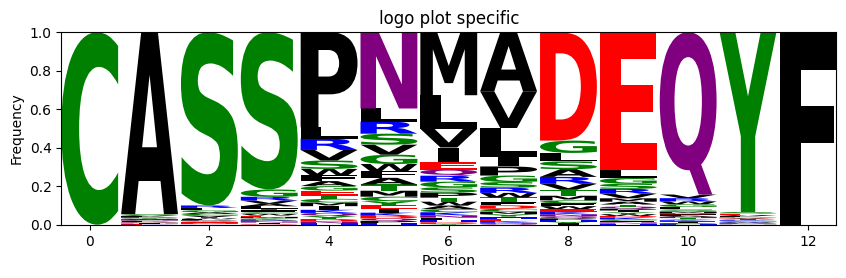

<Figure size 1000x400 with 0 Axes>

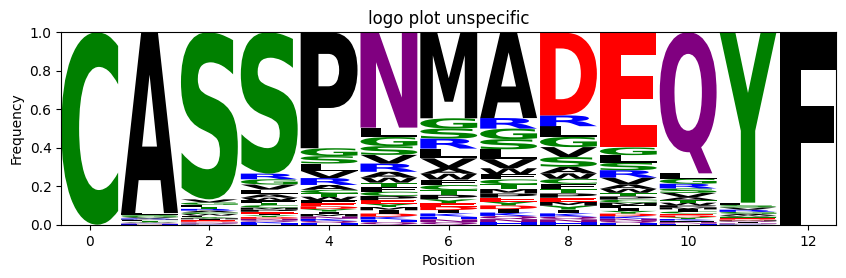

In [35]:
plot_logos(prob_mat_spec, 'logo plot specific')
plot_logos(prob_mat_unspec, 'logo plot unspecific')

In [58]:
probs_matrix_spec = logomaker.alignment_to_matrix(sequences=counts_specific, to_type='probability', pseudocount=0)
probs_matrix_unspec = logomaker.alignment_to_matrix(sequences=counts_unspecific, to_type='probability', pseudocount=0)

display(probs_matrix_spec, probs_matrix_unspec)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.945109,0.002815,0.002111,0.001407,0.002815,0.002111,0.001407,0.002111,0.001407,0.004222,0.002111,0.002815,0.004222,0.000704,0.002815,0.006334,0.002815,0.005630,0.003519,0.003519
2,0.008445,0.008445,0.002111,0.002815,0.004222,0.010556,0.000704,0.002111,0.000704,0.011963,0.002815,0.002815,0.003519,0.003519,0.012667,0.900070,0.006334,0.008445,0.004926,0.002815
3,0.012667,0.008445,0.002111,0.007037,0.009148,0.038001,0.002111,0.005630,0.005630,0.011963,0.007037,0.005630,0.005630,0.001407,0.019001,0.817030,0.009852,0.017593,0.008445,0.005630
4,0.026038,0.019001,0.012667,0.022519,0.030260,0.023223,0.007037,0.019001,0.016186,0.059113,0.019001,0.009852,0.494018,0.016186,0.058410,0.043631,0.020408,0.054891,0.033075,0.015482
5,0.034483,0.023223,0.014075,0.020408,0.035186,0.048557,0.009148,0.018297,0.016186,0.068262,0.030964,0.396200,0.011260,0.011963,0.062632,0.057002,0.032372,0.052076,0.036594,0.021112
6,0.018297,0.016186,0.008445,0.038705,0.011963,0.029557,0.011963,0.076003,0.016186,0.174525,0.327234,0.011963,0.026038,0.031668,0.030964,0.027445,0.021112,0.097115,0.020408,0.004222
7,0.306826,0.014778,0.017593,0.011260,0.018297,0.033779,0.011260,0.049965,0.009852,0.149894,0.014075,0.004926,0.047150,0.004926,0.026742,0.029557,0.022519,0.190711,0.023927,0.011963
8,0.040113,0.015482,0.562984,0.014778,0.014778,0.064039,0.008445,0.007741,0.012667,0.043631,0.023927,0.010556,0.009148,0.010556,0.035890,0.040816,0.030964,0.030964,0.014778,0.007741


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
pos,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.939637,0.002898,0.001076,0.001449,0.003105,0.006831,0.001118,0.002484,0.001490,0.007825,0.003146,0.001283,0.001118,0.001573,0.004637,0.007204,0.002774,0.006045,0.002194,0.002111
2,0.008901,0.008777,0.004099,0.004306,0.007452,0.012462,0.003643,0.004554,0.002194,0.011054,0.005548,0.003353,0.002898,0.003105,0.009067,0.868221,0.009978,0.016022,0.008115,0.006252
3,0.018051,0.012130,0.008653,0.009439,0.012834,0.027283,0.007162,0.009398,0.007369,0.024302,0.011261,0.008611,0.010474,0.007908,0.029395,0.734495,0.012793,0.026414,0.013207,0.008818
4,0.025420,0.017761,0.014739,0.015650,0.016933,0.040863,0.009315,0.012752,0.011592,0.038586,0.012627,0.011675,0.602592,0.010474,0.035688,0.038627,0.017637,0.037095,0.017140,0.012834
5,0.030595,0.022191,0.016105,0.018423,0.022936,0.047280,0.013621,0.016809,0.015070,0.048895,0.017099,0.495487,0.021529,0.013414,0.042726,0.045541,0.024137,0.045127,0.025793,0.017223
6,0.030057,0.026124,0.017802,0.018258,0.028070,0.053407,0.014863,0.017637,0.015898,0.050592,0.447048,0.014035,0.023267,0.013704,0.052000,0.052082,0.025172,0.050261,0.030016,0.019707
7,0.445930,0.025213,0.019251,0.020949,0.027946,0.054856,0.013828,0.017968,0.017554,0.051089,0.023185,0.015360,0.021611,0.016436,0.054856,0.052414,0.024716,0.047363,0.030223,0.019251
8,0.033907,0.026290,0.432102,0.020742,0.024965,0.053159,0.013497,0.019872,0.016312,0.055395,0.020701,0.014325,0.022357,0.014780,0.056098,0.050592,0.024675,0.051793,0.028484,0.019955


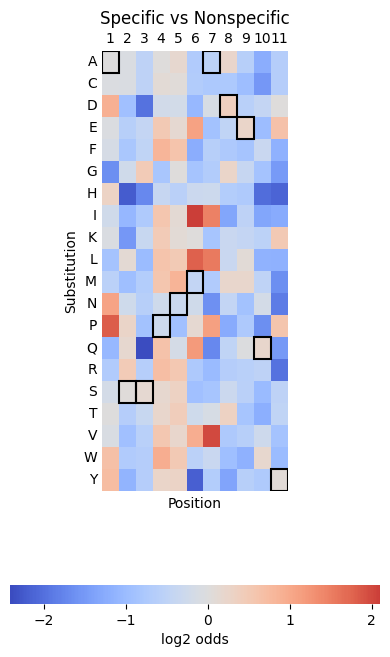

In [64]:
probs_matrix_spec = logomaker.alignment_to_matrix(sequences=counts_specific, to_type='probability', pseudocount=0)
probs_matrix_unspec = logomaker.alignment_to_matrix(sequences=counts_unspecific, to_type='probability', pseudocount=0)

wt_seq = "ASSPNMADEQY"

eps = 1e-4
log_odds = np.log2((probs_matrix_spec + eps) / (probs_matrix_unspec + eps))
log_odds_mid = log_odds[1:12]
plt.figure(figsize=(4,7))
ax = sns.heatmap(log_odds_mid.T, cmap='coolwarm', center=0, cbar_kws={'label': 'log2 odds', 'orientation': 'horizontal'})
ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
ax.set_aspect(1.3)
ax.set_xticks(np.arange(log_odds_mid.shape[0]) + 0.5)  # center
ax.set_xticklabels(np.arange(1, log_odds_mid.shape[0]+1))
ax.tick_params(axis='both', length=0)  # hide tick lines
ax.xaxis.tick_top()                 # tick labels
plt.title('Specific vs Nonspecific')
plt.xlabel("Position")
plt.ylabel("Substitution")

for i, aa in enumerate(wt_seq):
    if aa in log_odds.columns:
        y = log_odds.columns.get_loc(aa)
        x = i
        rect = plt.Rectangle(
            (x, y),
            1, 1,
            fill = False,
            edgecolor='black',
            lw=1.5,
            transform=ax.transData
        )


        ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [59]:
def compute_physicochemical_properties(df, seq_col='cdr3', label_col='specificity'):
    """
    Compute basic physicochemical properties (hydrophobicity, charge, etc.)
    for amino acid sequences in a DataFrame.
    """
    def analyze_seq(seq):
        seq = seq.replace('*', '')  # remove stop codons if any
        X = ProteinAnalysis(seq)
        return {
            'hydrophobicity': X.gravy(),
            'aromaticity': X.aromaticity(),
            'instability_index': X.instability_index(),
            'charge_at_pH7.4': X.charge_at_pH(7.4),
            'isoelectric_point': X.isoelectric_point(),
        }
    
    props = df[seq_col].apply(analyze_seq)
    props_df = pd.DataFrame(list(props))
    merged = pd.concat([df.reset_index(drop=True), props_df], axis=1)
    
    return merged

In [13]:
average_len = df_specific['cdr3'].apply(len).mean()
print(average_len)

13.0


In [8]:
ref = "ASSPNMADEQY"  # example reference string
def differs_in_max_4_consecutive(s, ref):
    #this functions checks if a CDR3b sequence differs from a wildtype sequence only in a tiled 4x pattern 
    # indices where characters differ
    diff_idx = [i for i, (a, b) in enumerate(zip(s, ref)) if a != b]

    # no differences → valid
    if not diff_idx:
        return True

    # check if differences fit in a window of size <= 4
    return max(diff_idx) - min(diff_idx) + 1 <= 4

In [9]:
df_rvl = pd.read_csv('../data/RVL_TCR-Engine paper_NGS_selected TCRs.csv')

display(df_rvl)

,Unnamed: 0,CDR3_seq_filtered,freq_1,freq_2,freq_3,freq_4,seq_representation,freq2-1,freq3-1,freq4-1,...,TITIN_score2,TITIN_total_score,TITIN_high_confidence_candidates,TITIN-and-MAGE_enriched_f1,TITIN-and-MAGE_f2,TITIN-and-MAGE_f3,score1.1,score2.1,Titn-and-MAGE_total,Titin-and-MAGE_candidates
0,2384,ASGINLASGQF,0.000103,0.002659,0.006740,NaN,3,25.920000,65.699692,0.000000,...,243,1000,0,1,0,1,24,243,1000,0
1,296,ASGINIVDEQY,0.000256,0.006411,0.011800,0.000113,4,24.995820,46.009459,0.438774,...,232,1000,0,1,0,1,45,232,1000,0
2,7498,AGGISLVSEQF,0.000026,0.001072,0.003340,NaN,3,41.870234,130.468750,0.000000,...,244,1000,0,1,0,1,8,244,1000,0
3,2825,ASGTNLVSEQF,0.000103,0.001958,0.005020,NaN,3,19.088373,48.933598,0.000000,...,245,1000,0,1,0,1,40,245,1000,0
4,7324,ASSPSIVDEQF,0.000026,0.001402,0.002640,NaN,3,54.753359,103.125000,0.000000,...,246,1000,0,1,0,1,13,246,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1639,ASGTSPVNEQF,0.000128,0.000474,0.000032,NaN,3,3.697119,0.247982,0.000000,...,521,1000,0,0,0,0,483,521,1000,0
519,996,AGGRSPVDGQF,0.000154,0.000124,0.000032,NaN,3,0.803720,0.206652,0.000000,...,522,1000,0,0,0,0,486,522,1000,0
520,554,ASGTSRASGQY,0.000205,0.000021,0.000032,NaN,3,0.100402,0.154989,0.000000,...,523,1000,0,0,0,1,488,523,1000,0
521,5891,SSSHNVVDEQY,0.000051,0.000206,0.000159,0.000225,4,4.018129,3.098480,4.387232,...,148,1000,0,1,1,0,324,148,1000,0


In [21]:
df_rvl_filtered = df_rvl[df_rvl["CDR3_seq_filtered"].apply(lambda s: differs_in_max_4_consecutive(s, ref))]
df_rvl_filtered.loc[:, 'CDR3_seq_filtered'] = ('C' + df_rvl_filtered['CDR3_seq_filtered'] + 'F')
display(df_rvl_filtered)

,Unnamed: 0,CDR3_seq_filtered,freq_1,freq_2,freq_3,freq_4,seq_representation,freq2-1,freq3-1,freq4-1,...,TITIN_score2,TITIN_total_score,TITIN_high_confidence_candidates,TITIN-and-MAGE_enriched_f1,TITIN-and-MAGE_f2,TITIN-and-MAGE_f3,score1.1,score2.1,Titn-and-MAGE_total,Titin-and-MAGE_candidates
12,4964,CASSRNIVDEQYF,0.000051,0.001340,0.002070,NaN,3,26.117875,40.350877,0.000000,...,254,1000,0,1,0,1,58,254,1000,0
14,8524,CASSKNLVDEQYF,0.000026,0.002267,0.001370,NaN,3,88.571602,53.515625,0.000000,...,256,1000,0,1,0,0,34,256,1000,0
28,8335,CASSPNIVDEQYF,0.000026,0.000660,0.000954,NaN,3,25.766289,37.265625,0.000000,...,266,1000,0,1,0,1,63,266,1000,0
30,4401,CASSKSIVDEQYF,0.000051,0.000515,0.001180,0.000037,4,10.045341,23.001949,0.730994,...,222,1000,0,1,0,1,92,222,1000,0
46,1892,CASSNNLVDEQYF,0.000128,0.002370,0.001240,NaN,3,18.485585,9.669747,0.000000,...,283,1000,0,1,0,0,187,283,1000,0
106,2185,CASGLNIADEQYF,0.000103,0.000453,0.000445,NaN,3,4.420468,4.337739,0.000000,...,339,1000,0,1,0,0,279,339,1000,0
127,7711,CASGKNIADEQYF,0.000026,0.000289,0.000159,NaN,3,11.272734,6.210938,0.000000,...,358,1000,0,1,0,0,233,358,1000,0
249,541,CASSRNLVDEQYF,0.000205,0.004205,0.006867,0.001951,4,20.494882,33.467530,9.506770,...,90,1000,0,1,1,1,75,90,165,0
272,640,CASSLNVVDEQYF,0.000205,0.000350,0.000477,0.000338,4,1.707909,2.324833,1.645402,...,199,1000,0,1,1,1,362,199,561,0
309,527,CASGLNLADEQYF,0.000205,0.002061,0.001210,0.000638,4,10.046511,5.897376,3.107980,...,175,1000,0,1,1,0,243,175,1000,0


In [22]:
df_rvl_sorted = df_rvl_filtered.sort_values(by=['freq3-1'])
display(df_rvl_sorted)

,Unnamed: 0,CDR3_seq_filtered,freq_1,freq_2,freq_3,freq_4,seq_representation,freq2-1,freq3-1,freq4-1,...,TITIN_score2,TITIN_total_score,TITIN_high_confidence_candidates,TITIN-and-MAGE_enriched_f1,TITIN-and-MAGE_f2,TITIN-and-MAGE_f3,score1.1,score2.1,Titn-and-MAGE_total,Titin-and-MAGE_candidates
416,62,CASSVSMVDEQYF,0.000385,0.001567,0.000064,0.000263,4,4.072196,0.165322,0.682538,...,228,1000,0,0,1,0,487,228,1000,0
515,421,CASSTNIADEQYF,0.000231,0.000144,0.000064,NaN,3,0.625118,0.275537,0.000000,...,518,1000,0,0,0,0,480,518,1000,0
492,5796,CASSMNTVDEQYF,0.000051,0.000289,0.000032,NaN,3,5.625380,0.619883,0.000000,...,495,1000,0,0,0,0,453,495,1000,0
445,7457,CASSPSIVDEQYF,0.000026,0.000165,0.000032,NaN,3,6.441562,1.242188,0.000000,...,448,1000,0,0,0,0,393,448,1000,0
272,640,CASSLNVVDEQYF,0.000205,0.000350,0.000477,0.000338,4,1.707909,2.324833,1.645402,...,199,1000,0,1,1,1,362,199,561,0
106,2185,CASGLNIADEQYF,0.000103,0.000453,0.000445,NaN,3,4.420468,4.337739,0.000000,...,339,1000,0,1,0,0,279,339,1000,0
309,527,CASGLNLADEQYF,0.000205,0.002061,0.001210,0.000638,4,10.046511,5.897376,3.107980,...,175,1000,0,1,1,0,243,175,1000,0
327,6570,CASSRNVVDEQYF,0.000051,0.000557,0.000318,0.000375,4,10.848967,6.198830,7.312047,...,109,1000,0,1,1,0,240,109,1000,0
127,7711,CASGKNIADEQYF,0.000026,0.000289,0.000159,NaN,3,11.272734,6.210938,0.000000,...,358,1000,0,1,0,0,233,358,1000,0
316,1475,CASSTSLVDEQYF,0.000128,0.001979,0.001180,0.000300,4,15.431442,9.201856,2.340126,...,188,1000,0,1,1,0,192,188,1000,0


In [26]:
df_rvl_sorted = df_rvl_sorted.rename(columns={'CDR3_seq_filtered': 'cdr3'})
display(df_rvl_sorted)

,Unnamed: 0,cdr3,freq_1,freq_2,freq_3,freq_4,seq_representation,freq2-1,freq3-1,freq4-1,...,TITIN_score2,TITIN_total_score,TITIN_high_confidence_candidates,TITIN-and-MAGE_enriched_f1,TITIN-and-MAGE_f2,TITIN-and-MAGE_f3,score1.1,score2.1,Titn-and-MAGE_total,Titin-and-MAGE_candidates
416,62,CASSVSMVDEQYF,0.000385,0.001567,0.000064,0.000263,4,4.072196,0.165322,0.682538,...,228,1000,0,0,1,0,487,228,1000,0
515,421,CASSTNIADEQYF,0.000231,0.000144,0.000064,NaN,3,0.625118,0.275537,0.000000,...,518,1000,0,0,0,0,480,518,1000,0
492,5796,CASSMNTVDEQYF,0.000051,0.000289,0.000032,NaN,3,5.625380,0.619883,0.000000,...,495,1000,0,0,0,0,453,495,1000,0
445,7457,CASSPSIVDEQYF,0.000026,0.000165,0.000032,NaN,3,6.441562,1.242188,0.000000,...,448,1000,0,0,0,0,393,448,1000,0
272,640,CASSLNVVDEQYF,0.000205,0.000350,0.000477,0.000338,4,1.707909,2.324833,1.645402,...,199,1000,0,1,1,1,362,199,561,0
106,2185,CASGLNIADEQYF,0.000103,0.000453,0.000445,NaN,3,4.420468,4.337739,0.000000,...,339,1000,0,1,0,0,279,339,1000,0
309,527,CASGLNLADEQYF,0.000205,0.002061,0.001210,0.000638,4,10.046511,5.897376,3.107980,...,175,1000,0,1,1,0,243,175,1000,0
327,6570,CASSRNVVDEQYF,0.000051,0.000557,0.000318,0.000375,4,10.848967,6.198830,7.312047,...,109,1000,0,1,1,0,240,109,1000,0
127,7711,CASGKNIADEQYF,0.000026,0.000289,0.000159,NaN,3,11.272734,6.210938,0.000000,...,358,1000,0,1,0,0,233,358,1000,0
316,1475,CASSTSLVDEQYF,0.000128,0.001979,0.001180,0.000300,4,15.431442,9.201856,2.340126,...,188,1000,0,1,1,0,192,188,1000,0


In [27]:
shared = df_rvl_sorted.merge(df, on='cdr3', how='inner', suffixes=("_rvl", 't4xNNK' ))
print(f"{len(shared)} / {len(df_rvl_sorted.index)} sequences found in large dataset")

display(shared)


7 / 20 sequences found in large dataset


,Unnamed: 0,cdr3,freq_1,freq_2,freq_3,freq_4,seq_representation,freq2-1,freq3-1,freq4-1,...,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity
0,7457,CASSPSIVDEQYF,0.000026,0.000165,0.000032,NaN,3,6.441562,1.242188,0.000000,...,0.000000,0.000004,0.000000,1.000000,0.209823,0.209823,NoChange,Depleted,Depleted,2
1,3545,CASSTNLVDEQYF,0.000077,0.003525,0.002320,0.000338,4,45.836515,30.169051,4.390078,...,0.000000,0.000026,0.000000,1.000000,0.036548,0.036548,NoChange,Depleted,Depleted,2
2,541,CASSRNLVDEQYF,0.000205,0.004205,0.006867,0.001951,4,20.494882,33.467530,9.506770,...,0.000000,0.000000,0.000046,0.021412,1.000000,46.702130,Depleted,NoChange,Enriched,0
3,965,CASSLNLVDEQYF,0.000154,0.003566,0.005660,0.000863,4,23.173951,36.781430,5.606556,...,0.000050,0.000000,0.000000,50.592456,50.592456,1.000000,Enriched,Enriched,NoChange,1
4,8335,CASSPNIVDEQYF,0.000026,0.000660,0.000954,NaN,3,25.766289,37.265625,0.000000,...,0.001424,0.000000,0.000000,1425.011959,1425.011959,1.000000,Enriched,Enriched,NoChange,1
5,4964,CASSRNIVDEQYF,0.000051,0.001340,0.002070,NaN,3,26.117875,40.350877,0.000000,...,0.000000,0.000011,0.000000,1.000000,0.081316,0.081316,NoChange,Depleted,Depleted,2
6,8524,CASSKNLVDEQYF,0.000026,0.002267,0.001370,NaN,3,88.571602,53.515625,0.000000,...,0.000000,0.000000,0.000116,0.008523,1.000000,117.332695,Depleted,NoChange,Enriched,0


In [29]:
shared[['enrich_pos_neg', 'enrich_pos_lib']].corr(method='spearman')

,enrich_pos_neg,enrich_pos_lib
enrich_pos_neg,1.000000,0.392678
enrich_pos_lib,0.392678,1.000000


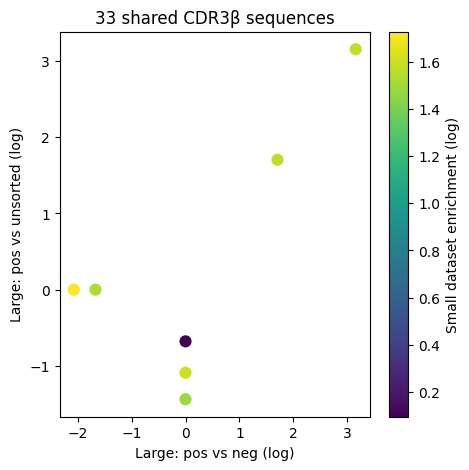

In [33]:
for col in ["freq3-1", "enrich_pos_neg", "enrich_pos_lib"]:
    shared[f"log_{col}"] = np.log10(shared[col] + 1e-6)


plt.figure(figsize=(5,5))
plt.scatter(
    shared["log_enrich_pos_neg"],
    shared["log_enrich_pos_lib"],
    c=shared["log_freq3-1"],
    cmap="viridis",
    s=60
)
plt.xlabel("Large: pos vs neg (log)")
plt.ylabel("Large: pos vs unsorted (log)")
plt.colorbar(label="Small dataset enrichment (log)")
plt.title("33 shared CDR3β sequences")
plt.show()

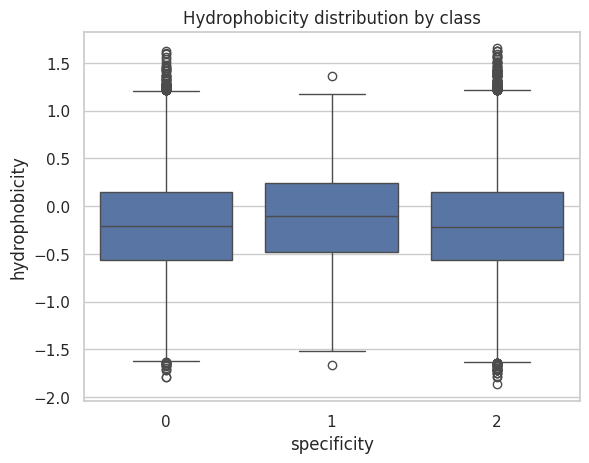

In [104]:
physicochem_props = compute_physicochemical_properties(df)
sns.boxplot(data=physicochem_props, x='specificity', y='hydrophobicity')
plt.title("Hydrophobicity distribution by class")
plt.show()

In [105]:
physicochem_props

,cdr3,frequency_pos,frequency_lib,frequency_neg,enrich_pos_neg,enrich_pos_lib,deplete_neg_lib,pos_vs_neg_status,pos_vs_lib_status,neg_vs_lib_status,specificity,hydrophobicity,aromaticity,instability_index,charge_at_pH7.4,isoelectric_point
0,CAAAASMADEQYF,0.000000,0.000000,0.000008,0.107417,1.000000,9.309478,Depleted,NoChange,Enriched,0,0.276923,0.153846,21.207692,-2.467989,4.050028
1,CAAACCMADEQYF,0.000000,0.000004,0.000000,1.000000,0.209823,0.209823,NoChange,Depleted,Depleted,2,0.584615,0.153846,80.084615,-2.516996,4.050028
2,CAAACQMADEQYF,0.000000,0.000000,0.000004,0.193996,1.000000,5.154739,Depleted,NoChange,Enriched,0,0.123077,0.153846,49.207692,-2.492492,4.050028
3,CAAAENMADEQYF,0.000000,0.000034,0.000000,1.000000,0.028659,0.028659,NoChange,Depleted,Depleted,2,-0.338462,0.153846,21.207692,-3.466868,4.050028
4,CAAAGGMADEQYF,0.000000,0.000000,0.000091,0.010822,1.000000,92.404260,Depleted,NoChange,Enriched,0,0.138462,0.153846,30.700000,-2.467989,4.050028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67479,CYYGLNMADEQYF,0.000000,0.000000,0.000012,0.074271,1.000000,13.464217,Depleted,NoChange,Enriched,0,-0.423077,0.307692,24.169231,-2.473000,4.050028
67480,CYYHFNMADEQYF,0.000000,0.000015,0.000000,1.000000,0.062252,0.062252,NoChange,Depleted,Depleted,2,-0.715385,0.384615,32.215385,-2.436374,4.353094
67481,CYYHVNMADEQYF,0.000000,0.000000,0.000017,0.056757,1.000000,17.618956,Depleted,NoChange,Enriched,0,-0.607692,0.307692,40.192308,-2.436374,4.353094
67482,CYYPSNMADEQYF,0.000007,0.000000,0.000000,8.084637,8.084637,1.000000,Enriched,Enriched,NoChange,1,-0.869231,0.307692,55.007692,-2.473000,4.050028


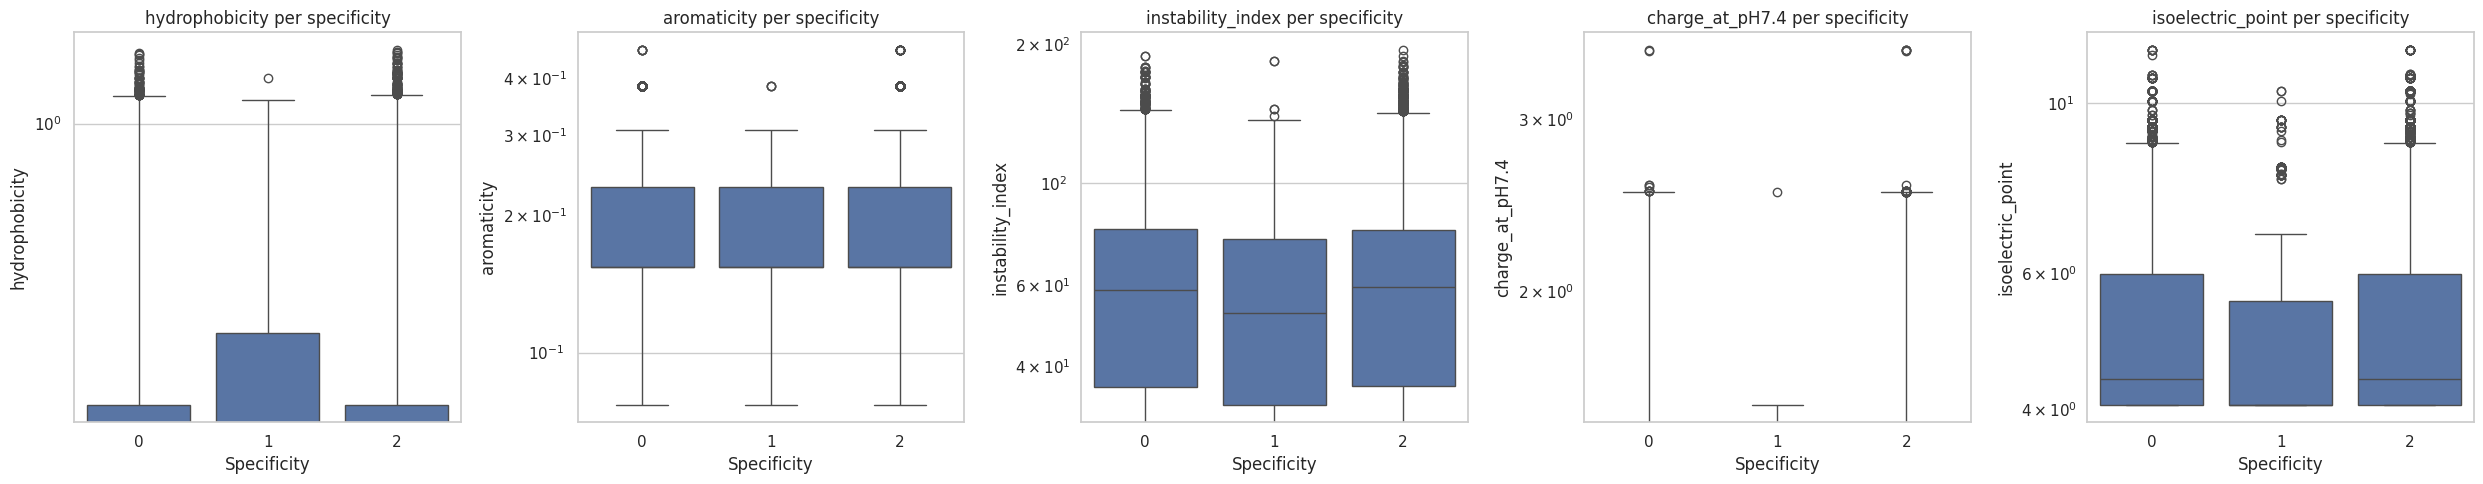

In [107]:
sns.set(style="whitegrid")

# List of physicochemical property columns
physico_cols = ['hydrophobicity', 'aromaticity', 'instability_index', 'charge_at_pH7.4', 'isoelectric_point']

# Create subplots
fig, axes = plt.subplots(1, len(physico_cols), figsize=(5 * len(physico_cols), 5))

for ax, col in zip(axes, physico_cols):
    sns.boxplot(x='specificity', y=col, data=physicochem_props, ax=ax)
    ax.set_title(f'{col} per specificity')
    ax.set_xlabel('Specificity')
    ax.set_ylabel(col)
    ax.set_yscale('log')  # optional, only if values span many orders of magnitude

plt.tight_layout()
plt.show()

In [112]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import umap

/cluster/project/reddy/marluca/NGS_pipeline/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NameError: name 'u' is not defined

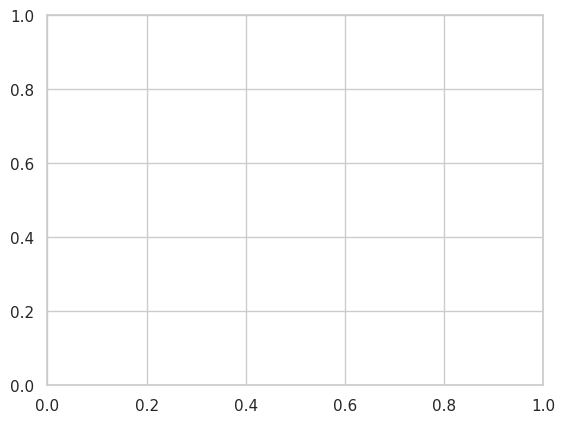

In [113]:
# Dimensionality reduction
# One-hot encode sequences
enc = OneHotEncoder(sparse_output=False)
X = enc.fit_transform([[aa for aa in s] for s in df['cdr3']])


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X)  # data: your feature matrix

In [1]:
# Assume 'embedding' is the 2D UMAP output
umap_df = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'specificity': df['specificity']  # your label column
})

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df, 
    x='UMAP1', 
    y='UMAP2', 
    hue='specificity',  # color by this column
    palette='tab10',    # or 'viridis', 'Set2', etc.
    s=50,               # marker size
    alpha=0.8
)
plt.title('UMAP of CDR3 sequences colored by specificity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.legend(title="specificity", loc=4, fontsize='small', fancybox=True)
plt.show()

NameError: name 'pd' is not defined